This is the main notebook where we will redistrict Iowa.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 

# Prepping the census and geopandas dataframes

In [2]:
df=pd.read_csv('census.csv')
df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,1,41.328528,-94.478164
1,1,Adams,3704,3,41.021656,-94.696906
2,2,Allamakee,14061,5,43.274964,-91.382751
3,3,Appanoose,12317,7,40.744683,-92.870345
4,4,Audubon,5674,9,41.679178,-94.904312


In [3]:
df['COUNTYFP10']=df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   county_id   99 non-null     int64  
 1   county      99 non-null     object 
 2   population  99 non-null     int64  
 3   COUNTYFP10  99 non-null     object 
 4   latitude    99 non-null     float64
 5   longitude   99 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 4.8+ KB


In [5]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp')
shapefile_iowa.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,19064,10257,8472,335,17980,7652,9146,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,14023,6862,6940,221,13844,4678,8232,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861..."
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,8502,3385,4951,166,8617,2249,5877,491,4,"POLYGON ((-95.26926 43.25537, -95.26140 43.255..."
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,6483,2469,3911,103,6370,1662,4362,346,4,"POLYGON ((-95.20902 41.86371, -95.20890 41.863..."
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,9138,4806,4164,168,9129,3237,5317,575,1,"POLYGON ((-91.25080 42.64558, -91.25160 42.645..."


# Merging pd and gpd dataframes and creating population heat map

## Prepping the data

In [6]:
map_population_by_county_data = shapefile_iowa.merge(df, on='COUNTYFP10')
county_populations = np.array(df['population'])
state_population = sum(county_populations)
df.sort_values('population', ascending=False).head()

,county_id,county,population,COUNTYFP10,latitude,longitude
76,76,Polk,492401,153,41.684281,-93.569720
56,56,Linn,230299,113,42.077951,-91.597673
81,81,Scott,174669,163,41.641679,-90.622290
51,51,Johnson,152854,103,41.668737,-91.588812
6,6,Black Hawk,131144,013,42.472888,-92.306059


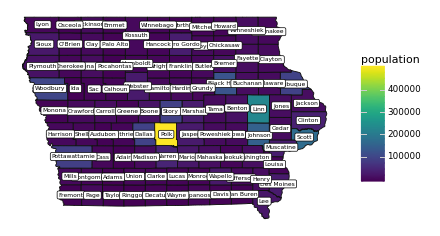

<ggplot: (354704688)>

In [7]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

## Population heat map for Iowa

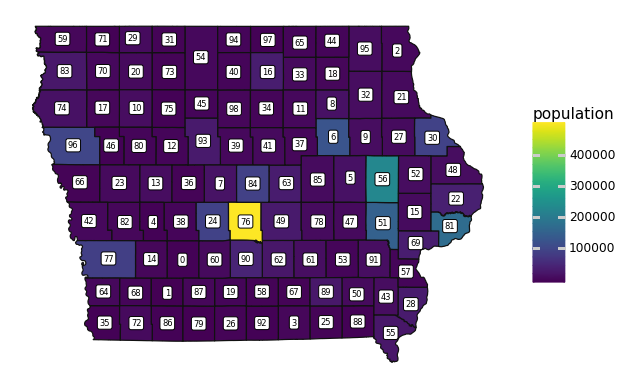

<ggplot: (354837468)>

In [8]:
map_by_county_id = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_by_county_id

# Analysis of county sizes in Iowa and Oregon

## Importing Oregon information

In [9]:
or_census=pd.read_csv('oregon_redistricting/oregon_census.csv')

In [10]:
or_census.head()

,County_ID,County_Name,Population2020e,Population2010,Latitude,Longitude,Change2010_2020
0,0,Baker,16910,16134,44.7346,-117.6777,776
1,1,Benton,94665,85579,44.4929,-123.3844,9086
2,2,Clackamas,426515,375992,45.3088,-122.3999,50523
3,3,Clatsop,39455,37039,46.1068,-123.8773,2416
4,4,Columbia,53280,49351,45.9189,-122.9863,3929


## Boxplots and swarmplots for county populations

<AxesSubplot:xlabel='Population2020e'>

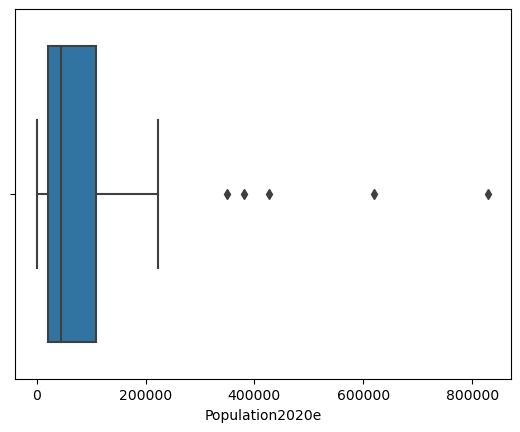

In [11]:
sns.boxplot(x=or_census['Population2020e'])

<AxesSubplot:xlabel='population'>

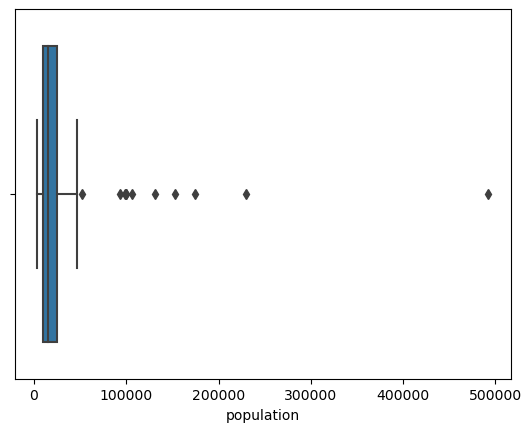

In [12]:
sns.boxplot(x=df['population'])

In [13]:
ia_array = df['population'].to_numpy()
or_array= or_census['Population2020e'].to_numpy()

In [14]:
df['population'].describe()

count        99.000000
mean      32225.949495
std       59658.599500
min        3704.000000
25%        9973.000000
50%       15211.000000
75%       25281.500000
max      492401.000000
Name: population, dtype: float64

In [15]:
df['population'].mean()/.2

161129.74747474748

In [16]:
pops=np.concatenate((ia_array, or_array),axis=0)

In [17]:
states=np.concatenate((np.array(['Iowa']*99), np.array(['Oregon']*36)),axis=0)


In [18]:
pop_df = pd.DataFrame({"state": states, "population": pops})

In [19]:
pop_df.head()

,state,population
0,Iowa,7496
1,Iowa,3704
2,Iowa,14061
3,Iowa,12317
4,Iowa,5674


<AxesSubplot:xlabel='population', ylabel='state'>

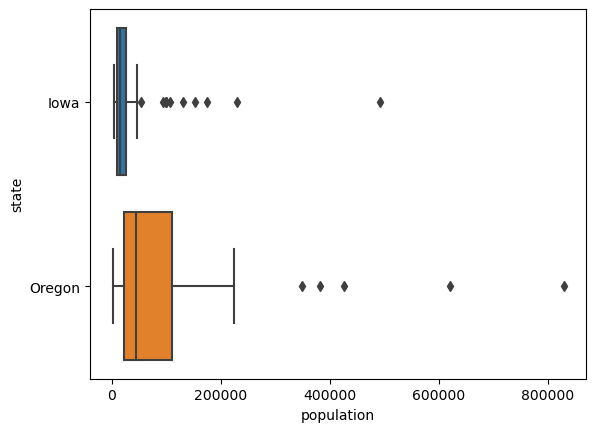

In [20]:
sns.boxplot(data=pop_df, x='population',y='state')

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 41.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


<AxesSubplot:xlabel='state', ylabel='population'>

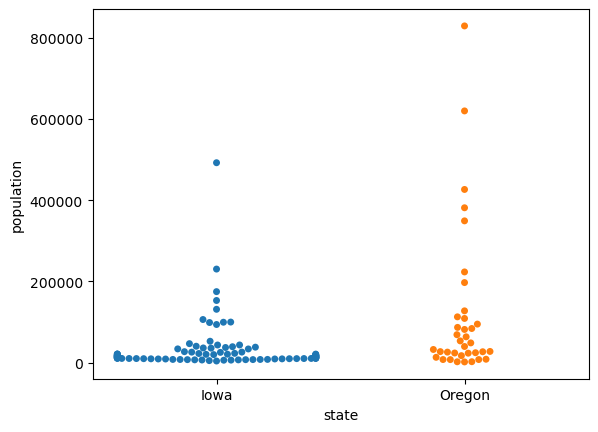

In [21]:
sns.swarmplot(data=pop_df, y='population',x='state')

<AxesSubplot:xlabel='population', ylabel='Count'>

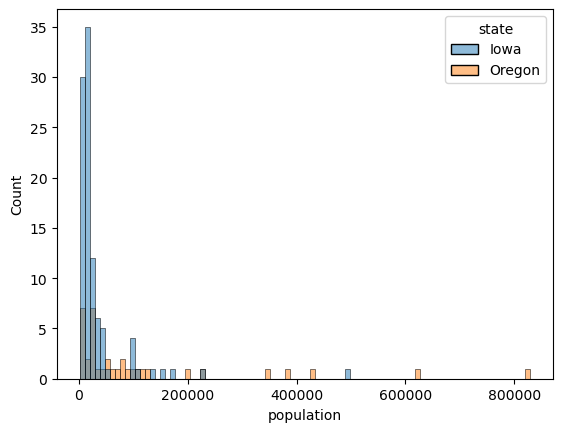

In [22]:
sns.histplot(data=pop_df, x='population', hue='state',bins=90)

# Creating the adjacency matrix for Iowa counties

In [23]:
shapefile_alpha=shapefile_iowa.sort_values('NAME10',ignore_index=True).copy()

In [24]:
shapefile_alpha.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3996,1790,2114,92,3811,1133,2461,217,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157..."
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,2185,1028,1108,49,2106,565,1395,146,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158..."
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,6934,3553,3264,117,6923,2421,4093,409,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500..."
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,6245,2951,3161,133,6136,1814,4033,289,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812..."
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,3457,1611,1802,44,3412,1080,2136,196,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688..."


In [25]:
# full statewide adjacency matrix (first boolean, then casting as int)
#   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
#   also should do this operation after any sorting of the original shapefile

n_counties = 99

ia_adjac_matrix = pd.DataFrame()

for j in range(n_counties):
    ia_adjac_matrix[j] = shapefile_alpha.intersects(shapefile_alpha.iloc[[j]].unary_union)
ia_adjac_matrix = ia_adjac_matrix - np.identity(99)
ia_adjac_matrix = ia_adjac_matrix.astype(int)

ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)



# Optimization Model

## Creating decision variables, model, and objective function

In [26]:
zp_county=np.array((df['county_id']).astype(str).str.pad(2,fillchar='0'))

In [27]:
zp_county

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98'],
      dtype=object)

In [57]:
n_districts = 4

ideal_district_size=state_population/n_districts
district_maximum=int(ideal_district_size*1.01)
district_minimum=int(ideal_district_size*.99)

In [29]:
# Create the linear programming model.
model = LpProblem("Supply-Demand-Problem", LpMinimize) 
variable_names = [zp_county[i]+str(j) for j in range(n_districts)
                                for i in range(n_counties)]
variable_names.sort() 

# The Decision Variable is 1 if the county is assigned to the district.
DV_variable_y = LpVariable.matrix("Y", variable_names, cat="Binary")
assignment = np.array(DV_variable_y).reshape(n_counties,n_districts)

# # The Decision Variable is the population allocated to the district.
DV_variable_x = LpVariable.matrix("X", variable_names, cat="Integer",
                                  lowBound=0)
allocation = np.array(DV_variable_x).reshape(n_counties,n_districts)

In [30]:
# This objective minimizes the counties split among multiple districts.
objective_function = lpSum(assignment) 
model += objective_function

## Initial Assignment / Allocation Constraints

In [31]:
# Allocate 100% of the population from each county.
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_populations[i] , "Allocate All " + str(i)

In [32]:
print(allocation[0][1], county_populations[0])

X_001 7496


In [33]:
# This constraint makes assignment required for allocation.
# sum(county_populations) is the "big M"
for i in range(n_counties): 
    for j in range(n_districts):
        model += allocation[i][j] <= county_populations[i]*assignment[i][j] , "Allocation assignment of county" + str(i) + "to district" + str(j)
        model += allocation[i][j] >= .2*county_populations[i]*assignment[i][j], "Minimum allocation of county" + str(i) + "to" + str(j)

In [34]:
#numpy documentation for np array
#https://numpy.org/doc/stable/glossary.html#term-row-major
# Contiguous districts constraints
for j in range(n_districts):
    for i in range(n_counties):
        model += 3*assignment[i][j] <= lpSum(assignment[:,j][ia_adjac_matrix_bool[i]]), "Contiguity constraint for county " + str(i) +" in district " + str(j)

In [35]:
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= district_maximum , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= district_minimum , "District Size Minimum " + str(j)

In [36]:
# Only allow counties that meet certain critera to be split among multiple districts
# This not necessary for Iowa.
# for i in range(n_counties): 
#     if county_populations[i] <= 75000: 
#         model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment for county " + str(i) 
#     else:
#         model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments for county " + str(i)

In [38]:
model.solve(GLPK_CMD(options=["--mipgap", "0.05", "--gomory"])) 

print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/lj/f1ygs8y13w9crbf6d4d7mgcm0000gn/T/7ff48493f595453aae7464f5fc5a30b4-pulp.lp
 -o /var/folders/lj/f1ygs8y13w9crbf6d4d7mgcm0000gn/T/7ff48493f595453aae7464f5fc5a30b4-pulp.sol
 --mipgap 0.05 --gomory
Reading problem data from '/var/folders/lj/f1ygs8y13w9crbf6d4d7mgcm0000gn/T/7ff48493f595453aae7464f5fc5a30b4-pulp.lp'...
1394 rows, 792 columns, 5916 non-zeros
792 integer variables, 396 of which are binary
3117 lines were read
GLPK Integer Optimizer 5.0
1394 rows, 792 columns, 5916 non-zeros
792 integer variables, 396 of which are binary
Preprocessing...
1394 rows, 792 columns, 5916 non-zeros
792 integer variables, 396 of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.924e+05  ratio =  4.924e+05
GM: min|aij| =  3.844e-01  max|aij| =  2.601e+00  ratio =  6.766e+00
EQ: min|aij| =  1.579e-01  max|aij| =  1.000e+00  ratio =  6.331e+00
2N: min|aij| =  1.250e-01  max|aij| =  1.631e

In [39]:
# Access the results
for i in range(n_counties):
    for j in range(n_districts):
        if allocation[i][j].value() > 0:
            print('County %d assigned to district %d: ' % (i, j), allocation[i][j].value())

County 0 assigned to district 0:  7496
County 1 assigned to district 0:  3704
County 2 assigned to district 3:  14061
County 3 assigned to district 3:  12317
County 4 assigned to district 1:  5674
County 5 assigned to district 0:  25575
County 6 assigned to district 2:  131144
County 7 assigned to district 3:  26715
County 8 assigned to district 2:  24988
County 9 assigned to district 2:  20565
County 10 assigned to district 0:  20823
County 11 assigned to district 2:  14334
County 12 assigned to district 1:  9927
County 13 assigned to district 1:  20760
County 14 assigned to district 0:  13127
County 15 assigned to district 2:  18505
County 16 assigned to district 2:  43127
County 17 assigned to district 0:  11658
County 18 assigned to district 3:  12012
County 19 assigned to district 0:  9748
County 20 assigned to district 3:  16384
County 21 assigned to district 3:  17043
County 22 assigned to district 2:  46460
County 23 assigned to district 1:  16525
County 24 assigned to district

# Visualizing the districts

## Prepping the data for visualization

In [40]:
# Prepare data for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'County': i,
            'District': j+1,
            'Assignment': int(assignment[i][j].value()*(j+1)),
            'Allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['Assignment'] != 0]
results = results.sort_values(['County', 'District'])


In [41]:
results

,County,District,Assignment,Allocation
0,0,1,1,7496
4,1,1,1,3704
11,2,4,4,14061
15,3,4,4,12317
17,4,2,2,5674
...,...,...,...,...
379,94,4,4,10679
383,95,4,4,20070
385,96,2,2,105941
391,97,4,4,7443


In [42]:
df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [43]:
results = results.merge(df, left_on='County', right_on='county_id',suffixes=('_ID', '_Name'))


In [44]:
results

,County,District,Assignment,Allocation,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,1,1,7496,0,Adair,7496,001,41.328528,-94.478164
1,1,1,1,3704,1,Adams,3704,003,41.021656,-94.696906
2,2,4,4,14061,2,Allamakee,14061,005,43.274964,-91.382751
3,3,4,4,12317,3,Appanoose,12317,007,40.744683,-92.870345
4,4,2,2,5674,4,Audubon,5674,009,41.679178,-94.904312
...,...,...,...,...,...,...,...,...,...,...
97,94,4,4,10679,94,Winnebago,10679,189,43.378124,-93.743488
98,95,4,4,20070,95,Winneshiek,20070,191,43.292989,-91.850788
99,96,2,2,105941,96,Woodbury,105941,193,42.393220,-96.053296
100,97,4,4,7443,97,Worth,7443,195,43.373491,-93.248533


In [45]:
data=results.drop(columns=['County', 'population']).copy()

In [46]:
data

,District,Assignment,Allocation,county_id,county,COUNTYFP10,latitude,longitude
0,1,1,7496,0,Adair,001,41.328528,-94.478164
1,1,1,3704,1,Adams,003,41.021656,-94.696906
2,4,4,14061,2,Allamakee,005,43.274964,-91.382751
3,4,4,12317,3,Appanoose,007,40.744683,-92.870345
4,2,2,5674,4,Audubon,009,41.679178,-94.904312
...,...,...,...,...,...,...,...,...
97,4,4,10679,94,Winnebago,189,43.378124,-93.743488
98,4,4,20070,95,Winneshiek,191,43.292989,-91.850788
99,2,2,105941,96,Woodbury,193,42.393220,-96.053296
100,4,4,7443,97,Worth,195,43.373491,-93.248533


In [47]:
# results['Multiple_County_Name'] = results['County_Name'].shift(periods=1)
# results['Multiple_District'] = results['District'].shift(periods=1).fillna(99).astype(int)

# Edit the assignment for the case when a county has multiple assignments 
# for i in range(0,len(results)):
#     if results['County_Name'].loc[i] == results['Multiple_County_Name'].loc[i]:
#         results.loc[i, 'Assignment'] =   int(str(results['District'].loc[i]) + \
#                                                         str(results['Multiple_District'].loc[i]))
# results = results.sort_values(['District','County_Name'])
# results.index = results['County_ID']

## Creating the maps

In [48]:
color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

def iowa_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with county IDs labels
    (2) A map with county labels
    """
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county_id',size=2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    # plot_map_county_ids = (
    #     ggplot(map_data)
    # + geom_map(aes(fill=str('Assignment'))) 
    # + geom_label(aes(x='longitude', y='latitude', label='population', size=5), 
    #              show_legend=False)
    # + theme_minimal()
    # + theme(axis_text_x=element_blank(),
    #         axis_text_y=element_blank(),
    #         axis_title_x=element_blank(),
    #         axis_title_y=element_blank(),
    #         axis_ticks=element_blank(),
    #         panel_grid_major=element_blank(),
    #         panel_grid_minor=element_blank(),
    #         figure_size=(7, 4))
    # + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels
# , plot_map_county_ids


In [49]:
shapefile_iowa.head(2)

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,19064,10257,8472,335,17980,7652,9146,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,14023,6862,6940,221,13844,4678,8232,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861..."


In [50]:
results.head(2)

,County,District,Assignment,Allocation,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,1,1,7496,0,Adair,7496,001,41.328528,-94.478164
1,1,1,1,3704,1,Adams,3704,003,41.021656,-94.696906


In [51]:
df.head(2)

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906


In [52]:
map_first_pass = shapefile_iowa.merge(data, left_on='COUNTYFP10', right_on='COUNTYFP10')
# map_first_pass['District'] = map_first_pass['District']+1



In [53]:
map_first_pass.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,PRES16OTH,CD,geometry,District,Assignment,Allocation,county_id,county,latitude,longitude
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122...",2,2,40105,63,Marshall,42.041691,-92.981452
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861...",1,1,25575,5,Benton,42.092547,-92.057630
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,491,4,"POLYGON ((-95.26926 43.25537, -95.26140 43.255...",4,4,16384,20,Clay,43.079822,-95.149726
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,346,4,"POLYGON ((-95.20902 41.86371, -95.20890 41.863...",2,2,11746,82,Shelby,41.679014,-95.308917
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,575,1,"POLYGON ((-91.25080 42.64558, -91.25160 42.645...",4,4,17043,21,Clayton,42.840998,-91.323511


In [54]:
# map_first_pass['District'] = map_first_pass['District'].astype('category')
map_first_pass['Assignment'] = map_first_pass['Assignment'].astype("category")


In [55]:
data.loc[data['Assignment']==1]

,District,Assignment,Allocation,county_id,county,COUNTYFP10,latitude,longitude
0,1,1,7496,0,Adair,001,41.328528,-94.478164
1,1,1,3704,1,Adams,003,41.021656,-94.696906
5,1,1,25575,5,Benton,011,42.092547,-92.057630
10,1,1,20823,10,Buena Vista,021,42.741522,-95.141432
14,1,1,13127,14,Cass,029,41.333824,-94.933302
17,1,1,11658,17,Cherokee,035,42.742737,-95.633262
19,1,1,9748,19,Clarke,039,41.029191,-93.784096
25,1,1,9110,25,Davis,051,40.748089,-92.410345
26,1,1,7645,26,Decatur,053,40.736379,-93.784580
28,1,1,38910,28,Des Moines,057,40.915339,-91.186925


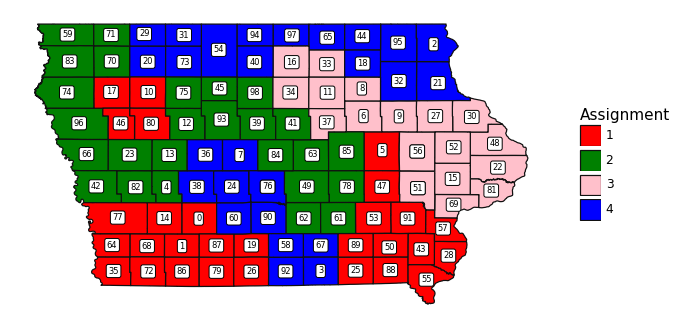

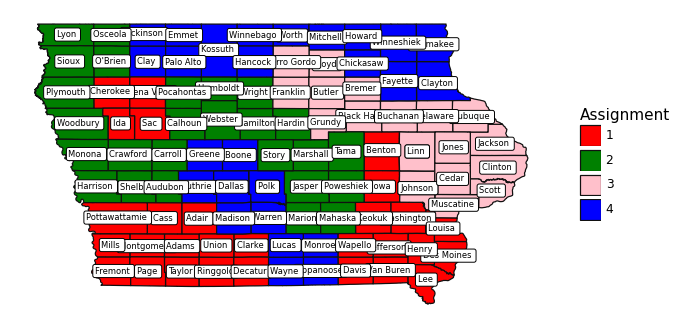

(<ggplot: (355519455)>, <ggplot: (355582598)>)

In [56]:
iowa_map(map_first_pass)

In [68]:
district_totals = pd.DataFrame(results.groupby('District')['Allocation'].sum().astype('int64'))
district_totals

,Allocation
District,
1,789616
2,805568
3,805470
4,789715
